# Problem Statement

Aura's e-commerce customer getmeatshirt.com desires to classify customer product reviews into good or bad with the help of a CNN-LSTM hybrid model.

## Dataset Description:

GrammarandProductReviews.csv [A subset of the dataset with 10000 reviews] to perform this task. This is a list of over 10000 reviews from 1000 different products provided by Datafiniti's Product Database. The dataset includes the text and title of the review, the name and manufacturer of the product, reviewer metadata, and more. We will consider only two columns namely revies.text and reviews.rating.

In [1]:
import numpy as np #linear algebra
import pandas as pd #data processing, CSV file I/O
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed
np.random.seed(32)

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# TensorFlow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Dropout,
    LSTM, Conv1D, MaxPooling1D,
    GlobalAveragePooling1D, Embedding, Activation)
from tensorflow.keras.models import Model

# Jupyter magic (only keep if using Jupyter Notebook)
# %matplotlib inline

2025-04-27 13:26:27.987435: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-27 13:26:27.988029: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-27 13:26:27.990356: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-27 13:26:27.995912: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745778388.005687    2669 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745778388.00

# 1. Load GrammarandProductReviews.csv dataset

In [2]:
df = pd.read_csv('GrammarandProductReviews.csv')

In [3]:
df.head()

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",2017-07-25T00:52:42Z,2018-02-05T08:36:58Z,6.03E+11,"602537205981,universalmusic/14331328,universal...",Universal Music Group / Cash Money,14331328,Pink Friday: Roman Reloaded Re-Up (w/dvd),...,NaN,0.0,5,https://redsky.target.com/groot-domain-api/v1/...,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,Joshua,6.03E+11
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor. This review was collected as part...,Good,NaN,NaN,Dorothy W,73416000391
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor.,Good,NaN,NaN,Dorothy W,73416000391
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,113026909.0,NaN,1,https://www.walmart.com/reviews/product/43383370,I read through the reviews on here before look...,Disappointed,NaN,NaN,Rebecca,67981934427
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,171267657.0,NaN,1,https://www.walmart.com/reviews/product/43383370,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,Walker557,67981934427


We will only consider the text of the reviews and the ratings.

We are going to make an approximation oin order to predict from the text the satisfaction level of the customer

(array([ 249.,    0.,  145.,    0.,    0.,  453.,    0., 2856.,    0.,
        6298.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

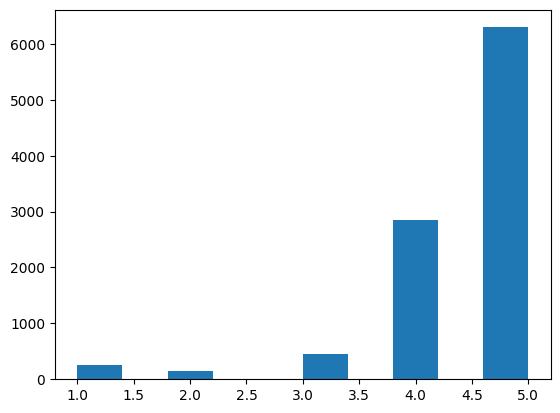

In [4]:
plt.hist(df['reviews.rating'])

## Observation
- The histogram plot shows the distribution/count of each ratings in the dataset

# 2. Create a feature named target by considering that a customer is pleased by the product if the rating is higher than 3. Any rating below 4 shows that the customer doesn't like the product. Use column reviews.rating to create feature target

In [5]:
df['target'] = df['reviews.rating'].apply(lambda x: 1 if x > 3 else 0)
# or
df['target'] = df['reviews.rating']<4

(array([9154.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         847.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

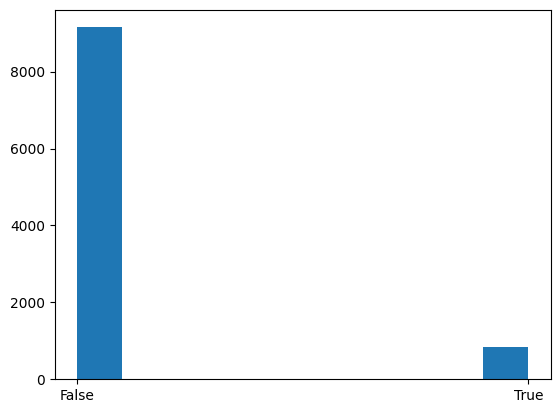

In [6]:
plt.hist(df['target'].astype(str))

## Observation
- The histogram plot shows the distribution of our good and bad reviews

We can see that we have a lot of "happy" customers due to our target distribution

# 3. Create your X with column reviews.text and Y with column target

# 4. Split your dataset into train and test in the ratio 80:20

In [7]:
train_text, test_text, train_y, test_y = train_test_split(df['reviews.text'], df['target'], test_size=0.2)

In [8]:
train_text.shape

(8000,)

# 5. Use tokenizer from Keras to vectorize the text samples into a 2D integer tensor with 20000 words. Fit your tokenizer on train data. (Max_NB_WORDS = 20000)

Preprocessing text for the (supervised)

Raw text requires (sometimes a lot of) preprocessing

The following cells uses Keras to preprocess text:

- using a tokenizer. You may use different tokenizers (from scikit-learn, NlTK, custom python function etc.) This converts the texts into sequences of indices representing the 20000 most frequent words.
- sequences have different lengths, so we pad them (add 0s at the end until the sequence is of 1000)
- we convert the output classes as 1-hot encodings


In [9]:
MAX_NB_WORDS = 20000

# get the raw text data
texts_train = train_text.astype(str)
texts_test = test_text.astype(str)

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)

# 6. Convert train texts to sequences using tokenizer texts_to_seqeuences method.

In [10]:
sequences = tokenizer.texts_to_sequences(texts_train)

# 7. Convert test texts to sequences using tokenizers texts_to_sequences method

In [11]:
sequences_test = tokenizer.texts_to_sequences(texts_test)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9279 unique tokens.


In [12]:
sequences[0]

[115,
 51,
 58,
 26,
 1017,
 43,
 488,
 26,
 224,
 270,
 4,
 826,
 5,
 15,
 9,
 16,
 10,
 14,
 8,
 3,
 17]

The tokenizer object stores a mapping (vocabulary) from word strings to token ids that can be inverted to reconstruct the original message (without formatting):

In [13]:
type(tokenizer.word_index), len(tokenizer.word_index)

(dict, 9279)

In [14]:
index_to_word = dict((i,w) for w, i in tokenizer.word_index.items())

In [15]:
" ".join([index_to_word[i] for i in sequences[0]])

'works really well on picking up spills on both carpet and tile this review was collected as part of a promotion'

The above code shows how to convert tokenized indicies back to sentences

Let's have a closer look at the tokenized sequences:

In [16]:
seq_lens = [len(s) for s in sequences]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % np.max(seq_lens))

average length: 32.3
max length: 1036


Using matplotlib backend: module://matplotlib_inline.backend_inline


(array([3.255e+03, 3.170e+03, 8.440e+02, 3.190e+02, 1.560e+02, 7.800e+01,
        6.500e+01, 3.600e+01, 2.100e+01, 1.700e+01, 1.000e+01, 7.000e+00,
        3.000e+00, 3.000e+00, 3.000e+00, 3.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00]),
 array([   0.  ,   20.72,   41.44,   62.16,   82.88,  103.6 ,  124.32,
         145.04,  165.76,  186.48,  207.2 ,  227.92,  248.64,  269.36,
         290.08,  310.8 ,  331.52,  352.24,  372.96,  393.68,  414.4 ,
         435.12,  455.84,  476.56,  497.28,  518.  ,  538.72,  559.44,
         580.16,  600.88,  621.6 ,  642.32,  663.04,  683.76,  704.48,
         725.2 ,  745

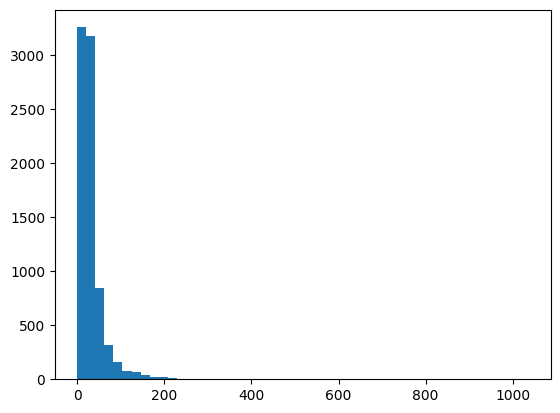

In [17]:
%matplotlib
import matplotlib.pyplot as plt

plt.hist(seq_lens, bins=50)

## Observations
- The histogram plot shows the number of words in reviews

Let's zoom on the distribution of regular sized posts. The vast majority of the posts have less than 200 symbols:

(array([9.000e+01, 1.500e+02, 7.540e+02, 1.033e+03, 9.320e+02, 1.077e+03,
        8.040e+02, 6.270e+02, 4.810e+02, 3.460e+02, 2.560e+02, 1.970e+02,
        1.810e+02, 1.460e+02, 1.250e+02, 8.800e+01, 8.300e+01, 8.300e+01,
        6.800e+01, 3.900e+01, 4.200e+01, 3.700e+01, 3.100e+01, 3.100e+01,
        1.800e+01, 2.500e+01, 1.800e+01, 1.600e+01, 1.200e+01, 1.200e+01,
        1.900e+01, 8.000e+00, 1.100e+01, 9.000e+00, 1.900e+01, 1.600e+01,
        1.100e+01, 8.000e+00, 8.000e+00, 6.000e+00, 5.000e+00, 2.000e+00,
        1.000e+00, 2.000e+00, 6.000e+00, 7.000e+00, 4.000e+00, 4.000e+00,
        4.000e+00, 2.000e+00]),
 array([  0.  ,   3.98,   7.96,  11.94,  15.92,  19.9 ,  23.88,  27.86,
         31.84,  35.82,  39.8 ,  43.78,  47.76,  51.74,  55.72,  59.7 ,
         63.68,  67.66,  71.64,  75.62,  79.6 ,  83.58,  87.56,  91.54,
         95.52,  99.5 , 103.48, 107.46, 111.44, 115.42, 119.4 , 123.38,
        127.36, 131.34, 135.32, 139.3 , 143.28, 147.26, 151.24, 155.22,
        159.2 , 

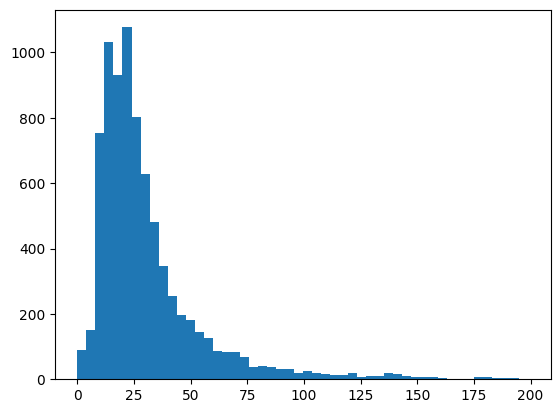

In [18]:
plt.hist([l for l in seq_lens if l <200], bins=50)

## Observation
- The histogram plot shows the most of the reviews has words less than 200

# 8. Pad train and test sequence (add 0s at the end until the sequence is of length 150). Consider MAX_SEQUENCE_LENGTH = 150 and this step gives your x_train and x_text

In [19]:
MAX_SEQUENCE_LENGTH = 150

# pad sequences with 0s
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print('Shape of data text tensor:', x_test.shape)

Shape of data tensor: (8000, 150)
Shape of data text tensor: (2001, 150)


# 9. One-hot encode your output classess (true/false)

In [20]:
y_train = train_y
y_test = test_y

y_train = to_categorical(np.asarray(y_train))
print('Shape of label tensor:', y_train.shape)
y_test = to_categorical(np.asarray(y_test))
print('Shape of label tensor:', y_test.shape)

Shape of label tensor: (8000, 2)
Shape of label tensor: (2001, 2)


In [21]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

# 10 Build a CNN - LSTM hybrid model with the following layers:
•Input layer with input shape = MAX_SEQUENCE_LENGTH and dtype int32

•Embedding layer with input dimension = MAX_NB_WORDS, output dimension =50, and input length = MAX_SEQUENCE_LENGTH 

•Conv1D layer with 64 filters and kernel size 5 and activation relu, followed by MaxPooling1D with pool size = 5 

Hint: MaxPool divides the length of the sequence by:

•Dropout(0.2)

•Conv1D layer with 64 filters and kernel size 5 and activation relu, followed by MaxPooling1D with pool size = 5

•Dropout(0.2)

•LSTM layer with 64 units

•Dense layer with 2 neurons and activation softmax


A simple supervised model in Keras

Vector space model is well known in information retrieval where each document is represented as a vector. The vector components represent weights or importance of each word in the document. The similarity between two documents is computed using the cosine similarity measure.

In [22]:
EMBEDDING_DIM = 50
N_CLASSES = 2

# input: a sequence of MAX_SEQEUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, 
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

# 1D convolution with 64 output channels
x = Conv1D(64, 5) (embedded_sequences)
x = Activation('relu')(x)
# MaxPool divides the length of the sequence by 5
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)
x = Conv1D(64, 5)(x)
x = Activation('relu')(x)
x = MaxPooling1D(5)(x)
# LSTM layer with a hidden size of 64
x = Dropout(0.2)(x)
x = LSTM(64)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(sequence_input, predictions)

/home/cullen-fedora/Documents/Python-Projects/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-04-27 13:26:30.370271: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


We have built an embedding layer mapping each word to a vector representation.

The goal here is to compute the vector representation of all words in each sequence and average them

# 11. Compile the model with Adam optimizer and metric accuracy

In [23]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

•Train the model for 5 epochs and batch size 64

In [24]:
history = model.fit(x_train, y_train, validation_split=0.1, epochs = 5, batch_size=64)

Epoch 1/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8884 - loss: 0.3603 - val_accuracy: 0.9112 - val_loss: 0.2951
Epoch 2/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9213 - loss: 0.2600 - val_accuracy: 0.9112 - val_loss: 0.2570
Epoch 3/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9253 - loss: 0.2106 - val_accuracy: 0.9237 - val_loss: 0.2240
Epoch 4/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9513 - loss: 0.1474 - val_accuracy: 0.9212 - val_loss: 0.2415
Epoch 5/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9758 - loss: 0.0826 - val_accuracy: 0.9200 - val_loss: 0.2656


•Evaluate the model on test text  and print the test loss and accuracy

In [25]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

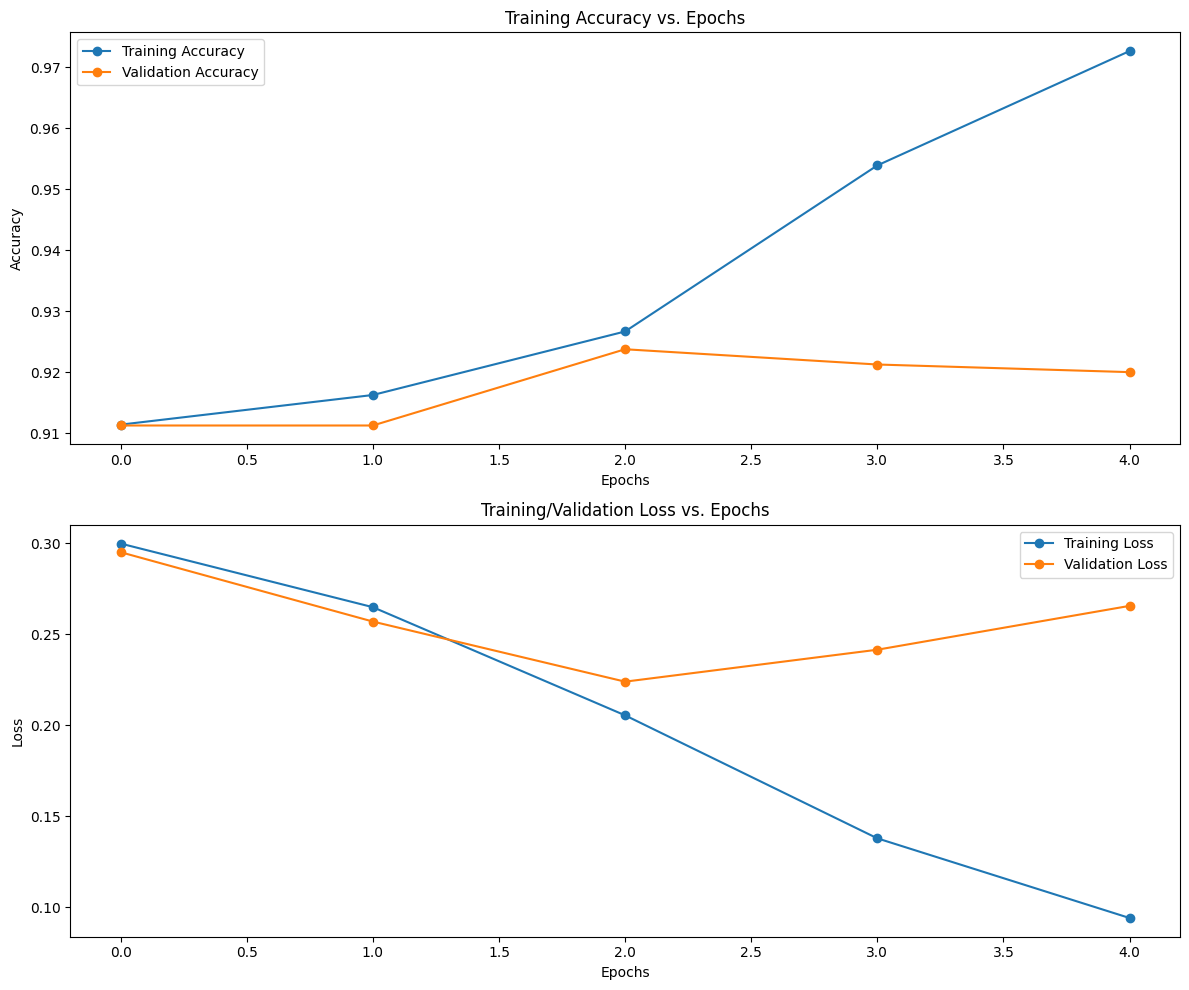

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Training Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Training Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

## Observations
- We see a constant decrease in the Training Loss where as validation loss starts increasing after a point
- The plot shows that the model starts getting to overfit, and we have a varianace problem here
- Adding regularization like drop-out and other techniques may help stabilize the performance

In [27]:
output_test = model.predict(x_test)
print('test auc:', roc_auc_score(y_test, output_test))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
test auc: 0.8042516221651637


In [28]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9153 - loss: 0.2531
Test Loss: 0.26515325903892517
Test Accuracy: 0.9150424599647522


## Observation
- The model has given a decent accuracy of 91.75% on unseen test dataset
- The AUC score on test dataset is 28%

Task B

•As a future and take-home task, train the model with the full dataset available in this link - 
Grammar and Online Product Reviews | Kaggle.

•Evaluate the model on full test data and compare the performance improvement from a subset of the full dataset

# Conclusion
- Deeplearning can be better on text classification than similiar ML techniques, but only on vary large datasets and well designed/tuned models.
- A CNN-LSTM hybrid networks give a solution to use both structural characterization and spatial information together.
- The following projects can replicated similar word embedding models much more efficiently: word2vec and gensim's word2vec (self-supervised learning only), fastText (both supervised and self-seupervised learning), Vowpal Wabbit (supervised learning).
- Plan shallow sparse TF-IDF bigrams features without any embedding and Logistic Regression or Multinominal Naiive Bayes is often competitive in small to medium datasets.